In [1]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper import FFM

# from fastfusion.mapper.FFM import make_pmappings, join_pmappings
# from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_rank_variable_bounds
# from fastfusion.mapper.metrics import Metrics

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    f"architecture/four_level.arch.yaml",
    "workloads/mha_full.workload.yaml",
    # "architecture/snowcat.arch.yaml",
    # "workloads/matmuls8_mixed.workload.yaml",
)
spec.mapper.ffm.metrics = FFM.Metrics.LATENCY | FFM.Metrics.ENERGY # | Metrics.RESOURCE_USAGE | Metrics.LATENCY
# spec.mapper.ffm.max_loops_minus_ranks = 4
dram = spec.arch.nodes["MainMemory"]
# dram.constraints.tensors.keep = "All()"

# spec.mapper.ffm.greedily_maximize_reuse = True
def filter_lambda(pm):
    return len(set(len(x.loops) for x in pm.compatibility.tensors if x.resource_name != "MainMemory")) <= 1

import os
import pickle
cache_file = "pmappings.pkl"
if os.path.exists(cache_file):
    pmappings = pickle.load(open(cache_file, "rb"))
else:
    pmappings = FFM.make_pmappings(spec)
    pickle.dump(pmappings, open(cache_file, "wb"))

# Prune reasons * nominal tile shapes may not be exactly equal to the final tile shapes.
# The code tracks the pruning rate as new tile shape choices are made. When the code
# tracks the pruning rate at a particular step, it assumes that all pruned choices have
# the same number of follow-on tile shape choices, which may not be true (e.g., if you
# pick a tile shape of 4 at a level, you may pick 1, 2, or 4 for the next level, but if
# you pick 1, you may only pick 1 for the next level).


# Total pmappings: 708252468
# Valid pmappings: 2523271
# Pareto-optimal pmappings: 24712

# Total pmappings: 708252468
# Valid pmappings: 296
# Pareto-optimal pmappings: 200

WARNING Loading configuration file from /root/.config/fastfusion/config.yaml
Generating pmapping templates for compute MAC Einsum I: 0it [00:00, ?it/s], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum V: 0it [00:00, ?it/s]], ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK_softmax: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum QK: 0it [00:00, ?it/s]
Generating pmapping templates for compute scalar_unit Einsum AV: 0it [00:00, ?it/s]
Generating pmapping templates for compute MAC Einsum QK_softmax: 0it [00:00, ?it/s]


ParseError: ParseError in I.input tensor renames: Expected expected_count=1 elements, got 0: frozenset(). Set expression: "Inputs() & Intermediates()". Symbol table:
	Nothing: InvertibleSet(frozenset())
	Tensors: InvertibleSet(frozenset({'I_in', 'I'}))
	All: InvertibleSet(frozenset({'I_in', 'I'}))
	Inputs: InvertibleSet(frozenset({'I_in'}))
	Outputs: InvertibleSet(frozenset({'I'}))
	Intermediates: InvertibleSet(frozenset({'I'}))
	Shared: InvertibleSet(frozenset({'I'}))
	I_in: InvertibleSet(frozenset({'I_in'}))
	I: InvertibleSet(frozenset({'I'}))
	d: InvertibleSet(frozenset({'d'}))
	m: InvertibleSet(frozenset({'m'}))
	b: InvertibleSet(frozenset({'b'}))
	Einsum: I
	Einsum_Object: type=None name='I' tensor_accesses=[TensorAccess(type=None, name='I_in', projection={'B': 'b', 'M': 'm', 'D': 'd'}, output=False, factors=['b', 'm', 'd']), TensorAccess(type=None, name='I', projection={'B': 'b', 'M': 'm', 'D': 'd'}, output=True, factors=['b', 'm', 'd'])] shape=[] is_copy_operation=True renames=[Rename(type=None, name='weight', source='Nothing()', expected_count=None), Rename(type=None, name='input', source='Inputs()', expected_count=None), Rename(type=None, name='output', source='Outputs()', expected_count=None)]
	weight: InvertibleSet(frozenset())
	input: InvertibleSet(frozenset({'I_in'}))
	output: InvertibleSet(frozenset({'I'}))

In [2]:
print(f'Total pmappings: {pmappings.total_pmappings()}')
print(f'Valid pmappings: {pmappings.valid_pmappings()}')
print(f'Pareto-optimal pmappings: {pmappings.pareto_optimal_pmappings()}')
print(f'Pmapping keep rates: {pmappings.pmapping_keep_rates()}')

per_einsum_totals = pmappings.total_pmappings(per_einsum=True)
per_einsum_valid = pmappings.valid_pmappings(per_einsum=True)
per_einsum_keep_rates = pmappings.pmapping_keep_rates(per_einsum=True)
per_einsum_pareto_optimal = pmappings.pareto_optimal_pmappings(per_einsum=True)

for einsum_name, npmappings in per_einsum_totals.items():
    print(f'Einsum {einsum_name} total pmappings: {npmappings}')
    print(f'Einsum {einsum_name} valid pmappings: {per_einsum_valid[einsum_name]}')
    print(f'Einsum {einsum_name} pmapping keep rates: {per_einsum_keep_rates[einsum_name]}')
    print(f'Einsum {einsum_name} pareto-optimal pmappings: {per_einsum_pareto_optimal[einsum_name]}')

Total pmappings: 15860
Valid pmappings: 15860
Pareto-optimal pmappings: 6432
Pmapping keep rates: {}
Einsum Matmul2 total pmappings: 2244
Einsum Matmul2 valid pmappings: 2244
Einsum Matmul2 pmapping keep rates: {}
Einsum Matmul2 pareto-optimal pmappings: 961
Einsum Matmul3 total pmappings: 2432
Einsum Matmul3 valid pmappings: 2432
Einsum Matmul3 pmapping keep rates: {}
Einsum Matmul3 pareto-optimal pmappings: 1025
Einsum Matmul1 total pmappings: 1022
Einsum Matmul1 valid pmappings: 1022
Einsum Matmul1 pmapping keep rates: {}
Einsum Matmul1 pareto-optimal pmappings: 281
Einsum Matmul4 total pmappings: 2244
Einsum Matmul4 valid pmappings: 2244
Einsum Matmul4 pmapping keep rates: {}
Einsum Matmul4 pareto-optimal pmappings: 961
Einsum Matmul5 total pmappings: 2058
Einsum Matmul5 valid pmappings: 2058
Einsum Matmul5 pmapping keep rates: {}
Einsum Matmul5 pareto-optimal pmappings: 897
Einsum Matmul6 total pmappings: 2244
Einsum Matmul6 valid pmappings: 2244
Einsum Matmul6 pmapping keep rates

In [3]:
import fastfusion.util as util
util.PARALLELIZE = False
mappings = FFM.join_pmappings(spec, pmappings)
# Compresssing pmappings: 100%|██████████| 10/10 [00:34<00:00,  3.44s/it]


Einsum Matmul1 has 281 pmappings with 281 compatibilities
Einsum Matmul2 has 961 pmappings with 961 compatibilities
Einsum Matmul3 has 1025 pmappings with 1025 compatibilities
Einsum Matmul4 has 961 pmappings with 961 compatibilities
Einsum Matmul5 has 897 pmappings with 897 compatibilities
Einsum Matmul6 has 961 pmappings with 961 compatibilities
Einsum Matmul7 has 1025 pmappings with 1025 compatibilities
Einsum Matmul8 has 321 pmappings with 321 compatibilities


Merging pmappings for Matmul7 <--> Matmul8 (8/8): 100%|██████████| 65/65 [00:02<00:00, 22.75it/s]


In [4]:
from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_num_computes
for c in sorted(mappings.data.columns):
    print(c)
energy = mappings.data["Total\0energy"].min()

num_computes = get_num_computes(spec)

print(f"Energy: {energy}")
print(f"Num computes: {num_computes}")

Matmul1 energy GlobalBuffer leak
Matmul1 energy GlobalBuffer read
Matmul1 energy GlobalBuffer write
Matmul1 energy MAC compute
Matmul1 energy MAC leak
Matmul1 energy MainMemory leak
Matmul1 energy MainMemory read
Matmul1 energy MainMemory write
Matmul1 latency GlobalBuffer
Matmul1 latency MainMemory
Matmul1 latency compute
Matmul1 mapping
Matmul1 tile_shape 0
Matmul1 tile_shape 1
Matmul1 tile_shape 2
Matmul1 tile_shape 3
Matmul1 tile_shape 4
Matmul1 tile_shape 5
Matmul2 energy GlobalBuffer leak
Matmul2 energy GlobalBuffer read
Matmul2 energy GlobalBuffer write
Matmul2 energy MAC compute
Matmul2 energy MAC leak
Matmul2 energy MainMemory leak
Matmul2 energy MainMemory read
Matmul2 energy MainMemory write
Matmul2 latency GlobalBuffer
Matmul2 latency MainMemory
Matmul2 latency compute
Matmul2 mapping
Matmul2 tile_shape 0
Matmul2 tile_shape 1
Matmul2 tile_shape 2
Matmul2 tile_shape 3
Matmul2 tile_shape 4
Matmul2 tile_shape 5
Matmul2 tile_shape 6
Matmul3 energy GlobalBuffer leak
Matmul3 ener

Matmul1 GlobalBuffer read
Matmul1 GlobalBuffer write
Matmul1 MainMemory read
Matmul1 MainMemory write
Matmul1 MAC compute
Matmul1 MainMemory leak
Matmul1 GlobalBuffer leak
Matmul1 MAC leak
Matmul2 GlobalBuffer read
Matmul2 GlobalBuffer write
Matmul2 MainMemory read
Matmul2 MainMemory write
Matmul2 MAC compute
Matmul2 MainMemory leak
Matmul2 GlobalBuffer leak
Matmul2 MAC leak
Matmul3 GlobalBuffer read
Matmul3 GlobalBuffer write
Matmul3 MainMemory read
Matmul3 MainMemory write
Matmul3 MAC compute
Matmul3 MainMemory leak
Matmul3 GlobalBuffer leak
Matmul3 MAC leak
Matmul4 GlobalBuffer read
Matmul4 GlobalBuffer write
Matmul4 MainMemory read
Matmul4 MainMemory write
Matmul4 MAC compute
Matmul4 MainMemory leak
Matmul4 GlobalBuffer leak
Matmul4 MAC leak
Matmul5 GlobalBuffer read
Matmul5 GlobalBuffer write
Matmul5 MainMemory read
Matmul5 MainMemory write
Matmul5 MAC compute
Matmul5 MainMemory leak
Matmul5 GlobalBuffer leak
Matmul5 MAC leak
Matmul6 GlobalBuffer read
Matmul6 GlobalBuffer write
Ma

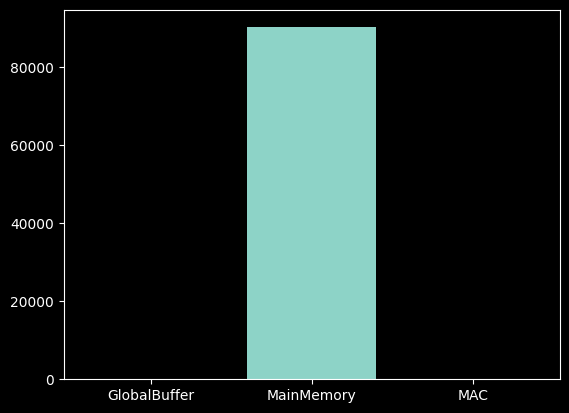

In [5]:
matmul3 = mappings[0].access("energy").drop("Total")
for c in matmul3.columns:
    print(c)
matmul3.sum(keep_key_index=1).columns

import matplotlib.pyplot as plt

results = matmul3.sum(keep_key_index=1).to_dict()
print(results)
plt.bar(results.keys(), results.values())
plt.show()

Merging with shared loops 1: Matmul3 <--> Matmul4.
Merging with shared loops 1: Matmul6 <--> Matmul7.
Merging with shared loops 0: Matmul1 <--> Matmul2.
Merging with shared loops 0: Matmul1,Matmul2 <--> Matmul3,Matmul4.
Merging with shared loops 0: Matmul1,Matmul2,Matmul3,Matmul4 <--> Matmul5.
Merging with shared loops 0: Matmul1,Matmul2,Matmul3,Matmul4,Matmul5 <--> Matmul6,Matmul7.
Merging with shared loops 0: Matmul1,Matmul2,Matmul3,Matmul4,Matmul5,Matmul6,Matmul7 <--> Matmul8.


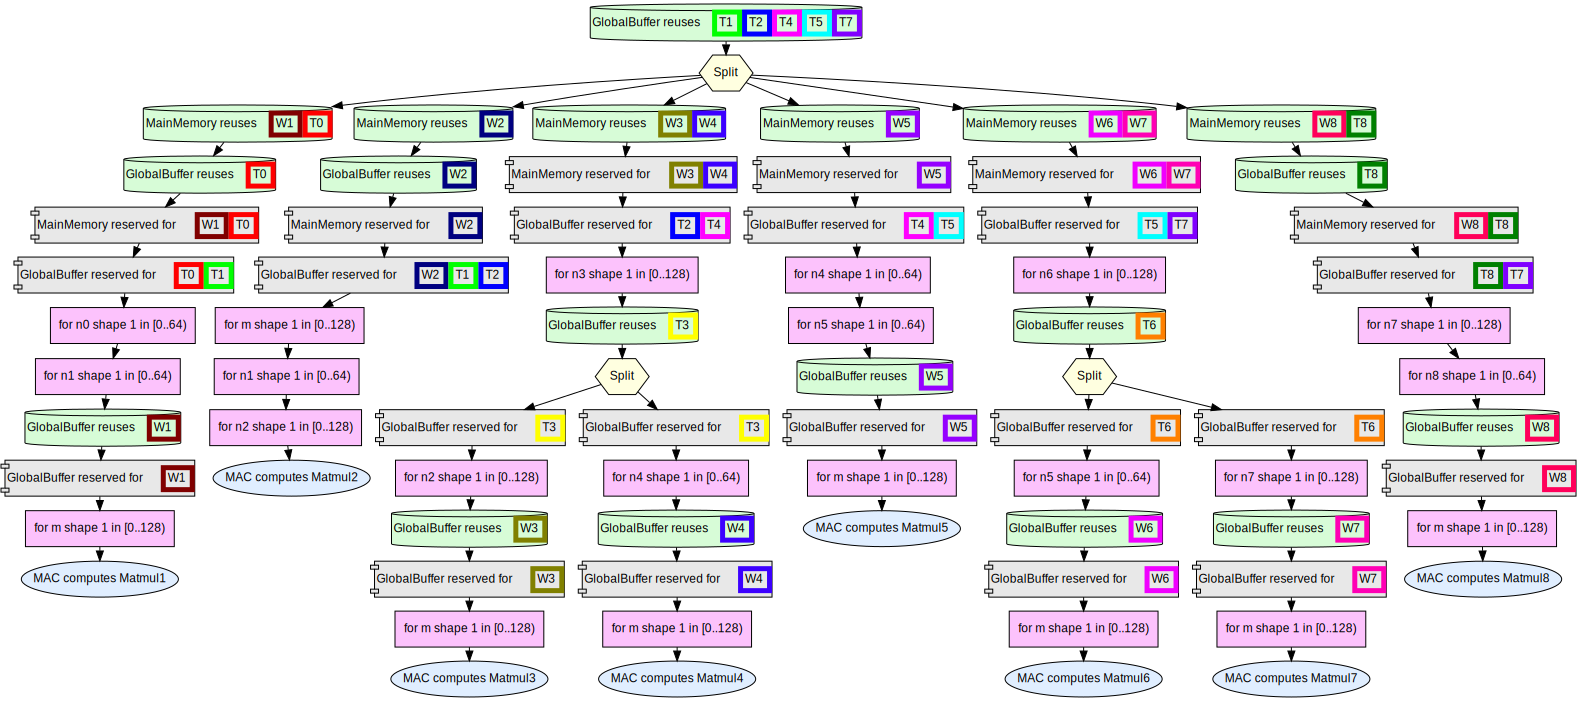

Total latency: 0.009437184000000001
Total energy: 90112.0
Matmul1 tile_shape 0: 128.0
Matmul1 tile_shape 1: 64.0
Matmul1 tile_shape 2: 64.0
Matmul1 tile_shape 3: 1.0
Matmul1 tile_shape 4: 1.0
Matmul1 tile_shape 5: 1.0
Matmul1 latency compute: 0.000524288
Matmul1 latency GlobalBuffer: 0
Matmul1 latency MainMemory: 0
Matmul1 energy GlobalBuffer read: 0
Matmul1 energy GlobalBuffer write: 0
Matmul1 energy MainMemory read: 12288.0
Matmul1 energy MainMemory write: 0
Matmul1 energy MAC compute: 0
Matmul1 energy MainMemory leak: 0
Matmul1 energy GlobalBuffer leak: 0
Matmul1 energy MAC leak: 0
Matmul1 mapping: type=None nodes=[Storage(type=None, tensors=['W1'], component='MainMemory', component_object=Memory(type=None, name='MainMemory', attributes=MemoryAttributes(type=None, global_cycle_period=1e-09, n_instances=1, energy_scale=1, area_scale=1, energy=None, area=None, datawidth={'All()': 1}, bandwidth_reads_plus_writes_per_cycle=inf, bandwidth_reads_per_cycle=inf, bandwidth_writes_per_cycle=i

KeyError: 'Total_Latency'

In [6]:
from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums

i = 0
rank_variable_bounds = get_rank_variable_bounds_for_all_einsums(spec)
mapping = make_mapping(mappings.data.iloc[i], einsum_names=spec.workload.einsum_names, rank_variable_bounds=rank_variable_bounds)
from IPython.display import SVG
display(SVG(mapping.render()))

for col in mappings.data.columns:
    print(f"{col}: {mappings.data.iloc[i][col]}")
    
# metric_Latency: 659328.583713355
# metric_Energy: 0.061079611244544

# metric_Latency: 1445760.583713355
# metric_Energy: 0.044033207435264


# Minimum latency: 396288.0
# Minimum energy: 0.043587645472768
# Minimum latency: 134745088.0
# Minimum energy: 0.043559639056384
# Minimum latency: 396288.0
# Minimum energy: 0.043599728214016004


print(f'Minimum latency: {mappings.data["Total_Latency"].min()}')
print(f'Minimum energy: {mappings.data["Total_Energy"].min()}')

In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
assert False
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
# pip3 install \
#     --extra-index-url=https://pypi.nvidia.com \
#     "cudf-cu12==25.6.*" "dask-cudf-cu12==25.6.*" "cuml-cu12==25.6.*" \
#     "cugraph-cu12==25.6.*" "nx-cugraph-cu12==25.6.*" "cuxfilter-cu12==25.6.*" \
#     "cucim-cu12==25.6.*" "pylibraft-cu12==25.6.*" "raft-dask-cu12==25.6.*" \
#     "cuvs-cu12==25.6.*" "nx-c ugraph-cu12==25.6.*"
# pip install \
#     --extra-index-url=https://pypi.anaconda.org/rapidsai-wheels-nightly/simple \
#     "cudf-cu12==25.6.*" "cuml-cu12==25.6.*"

# import cudf.pandas
# cudf.pandas.install()


from fastfusion import Specification
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN
from fastfusion.mapper.FFM import make_pmappings, join_pmappings

pmappings_file = "pmappings.pkl"
spec = Specification.from_yaml(
    # f"architecture/four_level.arch.yaml",
    # "workloads/mha_full.workload.yaml",
    # "workloads/mha_full.renames.yaml",
    "architecture/snowcat.arch.yaml",
    "workloads/matmuls8_mixed.workload.yaml",
)

spec.calculate_component_energy_area()
pmappings = make_pmappings(spec)
mappings = join_pmappings(spec, pmappings)

from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
from IPython.display import SVG
display(SVG(mappings.data.iloc[0][MAPPING_COLUMN].render()))


# result = {"FFM": mappings}

# if True:#not os.path.exists(pmappings_file):
#     spec.calculate_component_energy_area()
#     flattened_architecture = spec.get_flattened_architecture()

#     # Generate partial mappings
#     t0 = time.time()

#     metrics = Metrics.ENERGY# | Metrics.RESOURCE_USAGE
#     sims, decompress_data = get_sims(spec, flattened_architecture, metrics=metrics)# | Metrics.LATENCY)

#     pmapping_time = time.time() - t0
#     total_pmappings = sum(p.mappings.n_pmappings for v in sims.values() for p in v)
#     n_pmapping_group_optimal_mappings = sum(len(p.mappings.data) for v in sims.values() for p in v)
#     print(f'Took {pmapping_time:.2f} seconds to generate {total_pmappings} partial mappings ({total_pmappings / pmapping_time:.2f} per second). {n_pmapping_group_optimal_mappings} Pareto-optimal mappings ({n_pmapping_group_optimal_mappings / total_pmappings*100:.2f}% of total).')

#     pkl.dump((sims, flattened_architecture, decompress_data, metrics), open(pmappings_file, "wb"))
# else:
#     sims, flattened_architecture, decompress_data, metrics = pkl.load(open(pmappings_file, "rb"))


# # Join partial mappings
# t0 = time.time()
# mappings = join_sims(sims, spec, flattened_architecture, metrics=metrics)
# join_time = time.time() - t0
# mappings.decompress(decompress_data)

# # Runtime reporting
# print(f"Pmappings: {pmapping_time:.2f}. Joining: {join_time:.2f}. Total Pmappings: {total_pmappings}. Total mappings: {mappings.n_pmappings}. Time per pmapping: {pmapping_time / total_pmappings:.2e}")

# result = {"FFM": mappings}



In [ ]:
import importlib
import fastfusion.visualization.interactive
importlib.reload(fastfusion.visualization.interactive)
from fastfusion.visualization.interactive import plotly_show
from fastfusion.mapper.FFM._make_pmappings.mapper_multi_einsum import get_rank_variable_bounds_for_all_einsums
for mappings in result.values():
    mappings.make_pmapping_group(columns=["RESOURCE_GlobalBuffer_LEVEL_0", "Total_Energy"])
result2 = {k: v.data for k, v in result.items()}
# plotly_show(result2, "RESOURCE_GlobalBuffer_LEVEL_0", "Total_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))
plotly_show(result2, "Total_Energy", "Total_Energy", category="Category", logscales=True, einsum_names=spec.workload.einsum_names, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec))

# from fastfusion.mapper.FFM.deprecate_maybe.visualization import make_mapping
# from IPython.display import SVG
# newmapping = make_mapping(mappings.data.iloc[0], spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
# display(SVG(newmapping.render()))

In [ ]:
from IPython.display import SVG

from fastfusion.mapper.FFM._pmapping_group import row2pmappings
# importlib.reload(fastfusion.visualization.interactive)
# importlib.reload(fastfusion.frontend.mapping)
from fastfusion.frontend.mapping import Mapping, Fill, Reservation
from fastfusion.mapper.FFM._pmapping_group.df_convention import MAPPING_COLUMN

row = mappings.data.iloc[-1]
pmappings = row2pmappings(row, spec.workload.einsum_names, get_rank_variable_bounds_for_all_einsums(spec))
    
newmapping = Mapping.from_pmappings(pmappings, rank_variable_bounds=get_rank_variable_bounds_for_all_einsums(spec)).clear_nodes_of_type(Fill)
display(SVG(newmapping.render()))

# display(SVG(mappings.data.iloc[-1][MAPPING_COLUMN].render()))